In [1]:
from pathlib import Path
from tqdm.auto import tqdm
from IPython.display import clear_output

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.utils.vis_utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Dense, Reshape, Concatenate
from keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Conv2DTranspose, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam
import visualkeras

import matplotlib.pyplot as plt

import numpy as np
from numpy import ones, zeros, expand_dims, vstack, asarray
from numpy import linspace, arccos, clip, sin, cos, dot
from numpy.linalg import norm
from numpy.random import rand, randn, randint
import pandas as pd

# UTILS

In [2]:
cwd = Path.cwd()

OPT = Adam(learning_rate=0.0002, beta_1=0.5)

DATASET_INFO = {
    'mnist': {
        'class_names': [str(i) for i in range(10)],
        'input_shape': (28, 28, 1)
    },
    'fashion_mnist': {
        'class_names': ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 
                        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'],
        'input_shape': (28, 28, 1)
    },
    'cifar10':{
        'class_names': ['airplane', 'car', 'bird', 'cat', 'deer', 
                        'dog', 'frog', 'horse', 'ship', 'truck'],
        'input_shape': (32, 32, 3)
    }
}

In [3]:
def plot_data(data=None, dataset_name='mnist', n=5, 
              save=False, show=False,
              name=None, path='/plot_data/',
              fontsize=14, axis='off', cmap='gray_r'):

    images, labels = data
    figsize = (n*2, n*2)
    plt.figure(figsize=(figsize))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis(axis)
        plt.imshow(images[i].squeeze(), cmap=cmap)
        if labels is not None:
            plt.title(DATASET_INFO[dataset_name]['class_names'][labels[i].squeeze()], fontsize=fontsize)
    plt.tight_layout()
    if save:
        while name is None:
            name = input("Enter name for figure: ")

        file_path = cwd / Path('figures') / Path(path)
        file_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(file_path.joinpath(str(name) + '.png'))
    if show:
        plt.show()
    plt.close()

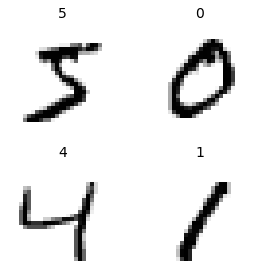

In [4]:
train, test = mnist.load_data()
plot_data(data=train, show=True, n=2)

# MODEL

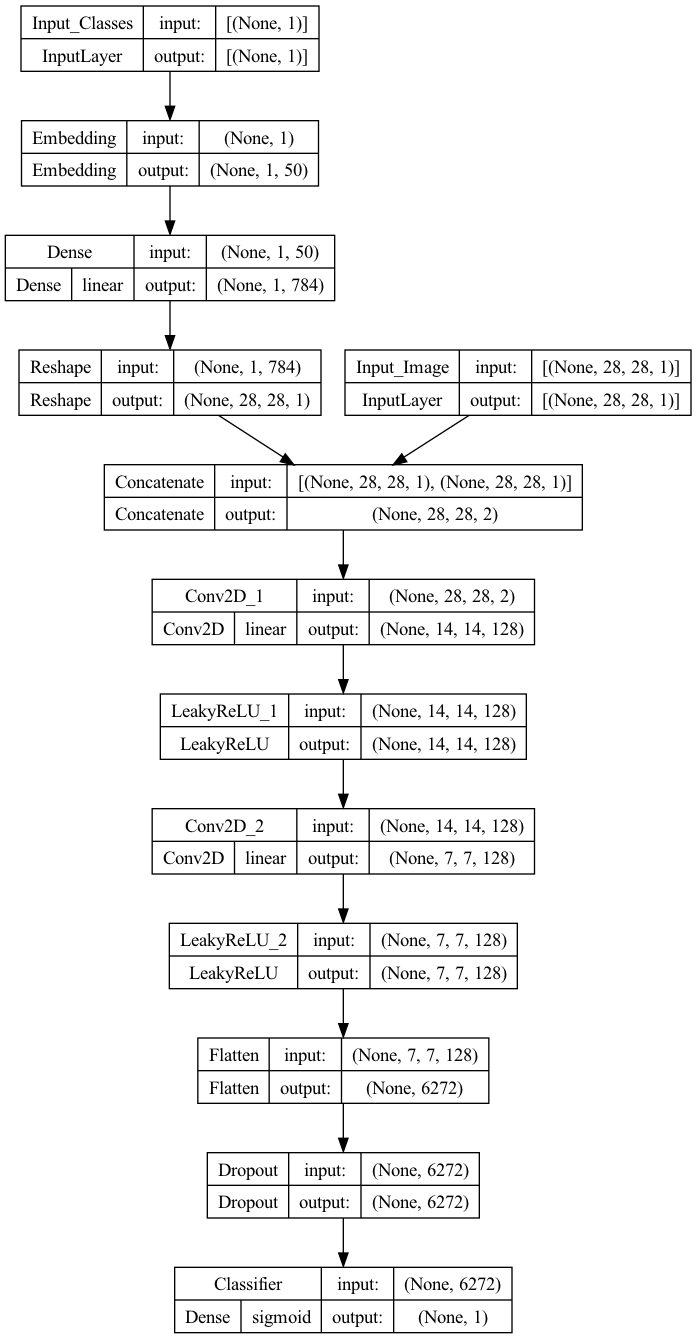

In [5]:
def define_discriminator(dataset_name='mnist', 
                         n_classes=10, opt=OPT):

    in_shape = DATASET_INFO[dataset_name]['input_shape']
    
    # LABEL INPUT
    in_label = Input(shape=(1,), name='Input_Classes')
    
    # EMBEDDING FOR CATEGORICAL INPUT
    li = Embedding(n_classes, 50, name='Embedding')(in_label)

    n_nodes = in_shape[0] * in_shape[1] * 1
    li = Dense(n_nodes, name='Dense')(li)

    # RESHAPING TO MATCH THE DIMENSIONS OF THE IMAGE
    li = Reshape((in_shape[0], in_shape[1], 1), name='Reshape')(li)
    
    # INPUT OF THE IMAGE
    in_image = Input(shape=in_shape, name='Input_Image')
    
    # CONCATENATE LABEL TO THE CHANNELS
    merge = Concatenate(name='Concatenate')([in_image, li])

    # DOWNSAMPLE 1
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', name='Conv2D_1')(merge)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_1')(fe)
    if in_shape[2] == 3: assert fe.shape == (None, 16, 16, 128)
    if in_shape[2] == 1: assert fe.shape == (None, 14, 14, 128)
    
    # DOWNSAMPLE 2
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', name='Conv2D_2')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_2')(fe)    
    if in_shape[2] == 3: assert fe.shape == (None, 8, 8, 128)
    if in_shape[2] == 1: assert fe.shape == (None, 7, 7, 128)

    # DOWNSAMPLE 3
    if in_shape[2] == 3:
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same', name='Conv2D_3')(fe)
        fe = LeakyReLU(alpha=0.2, name='LeakyReLU_3')(fe)    
        assert fe.shape == (None, 4, 4, 128)
    
    # FLATTEN
    fe = Flatten(name='Flatten')(fe)
    # DROPOUT
    fe = Dropout(0.4, name='Dropout')(fe)
    # OUTPUT
    out_layer = Dense(1, activation='sigmoid', name='Classifier')(fe)
    
    model = Model([in_image, in_label], out_layer)                            
    model.compile(loss='binary_crossentropy', 
                  optimizer=opt, 
                  metrics=['accuracy'])
    return model

model = define_discriminator()
plot_model(model, to_file='discriminator.png',
           show_dtype=False, show_shapes=True, 
           show_layer_activations=True, expand_nested=True)

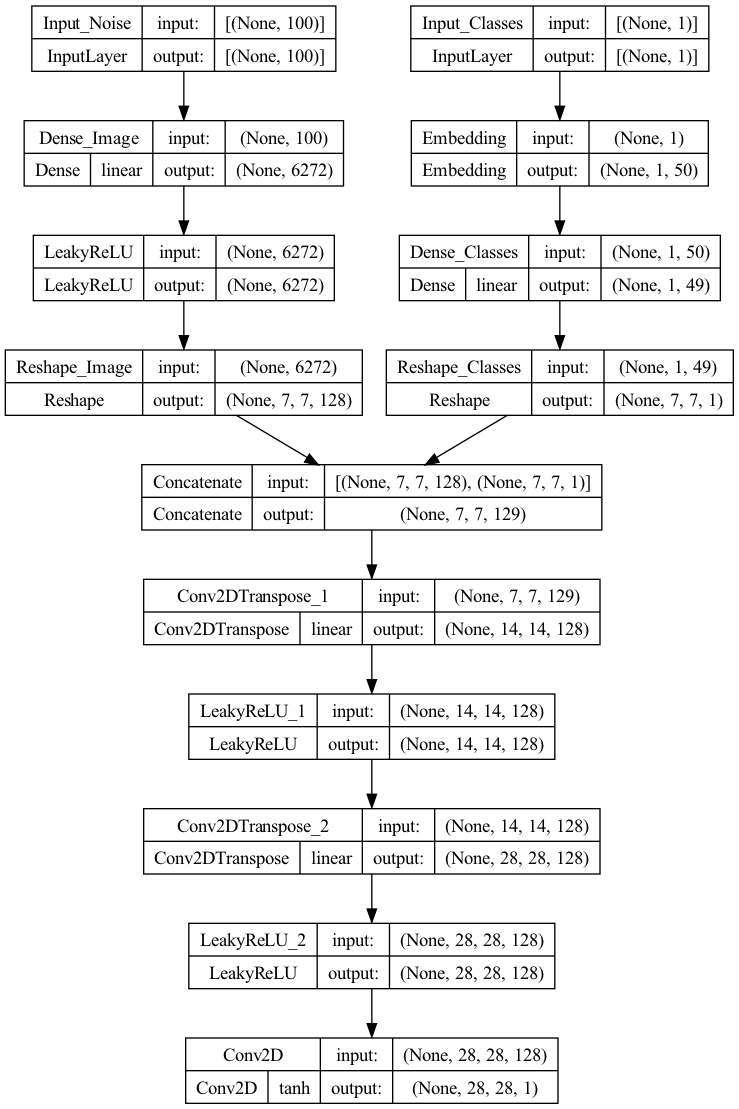

In [6]:
def define_generator(dataset_name='mnist',
                     latent_dim=100, 
                     n_classes=10):

    input_shape = DATASET_INFO[dataset_name]['input_shape']
    in_label = Input(shape=(1,), name='Input_Classes')
    li = Embedding(n_classes, 50, name='Embedding')(in_label)

    node = 7 
    if input_shape[2] == 3:
        node = 4

    n_nodes = node * node

    li = Dense(n_nodes, name='Dense_Classes')(li)
    li = Reshape((node, node, 1), name='Reshape_Classes')(li)

    in_lat = Input(shape=(latent_dim,), name='Input_Noise')
    
    # FOUNDATION FOR THE IMAGE
    n_nodes = 128 * node * node
    gen = Dense(n_nodes, name='Dense_Image')(in_lat)
    gen = LeakyReLU(alpha=0.2, name='LeakyReLU')(gen)
    gen = Reshape((node, node, 128), name='Reshape_Image')(gen)
    # merge image gen and label input
    merge = Concatenate(name='Concatenate')([gen, li])

    # UPSAMPLE 1
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name='Conv2DTranspose_1')(merge)
    gen = LeakyReLU(alpha=0.2, name='LeakyReLU_1')(gen)
    if input_shape[2] == 1: assert gen.shape == (None, 14, 14, 128)
    if input_shape[2] == 3: assert gen.shape == (None, 8, 8, 128)
    
    # UPSAMPLE 2
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name='Conv2DTranspose_2')(gen)
    gen = LeakyReLU(alpha=0.2, name='LeakyReLU_2')(gen)
    if input_shape[2] == 1: assert gen.shape == (None, 28, 28, 128)
    if input_shape[2] == 3: assert gen.shape == (None, 16, 16, 128)

    if input_shape[2] == 3:
        gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name='Conv2DTranspose_3')(gen)
        gen = LeakyReLU(alpha=0.2, name='LeakyReLU_3')(gen)
        if input_shape[2] == 3: assert gen.shape == (None, 32, 32, 128)
    
    # OUTPUT
    out_layer = Conv2D(input_shape[2], (7,7), activation='tanh', padding='same', name='Conv2D')(gen)
    assert out_layer.shape == (None, input_shape[0], input_shape[1], input_shape[2])
    
    model = Model([in_lat, in_label], out_layer)
    return model

model = define_generator()
plot_model(model, to_file='generator.png',
           show_dtype=False, show_shapes=True, 
           show_layer_activations=True, expand_nested=True)

In [7]:
def define_gan(g_model, d_model ,opt=OPT):
    d_model.trainable = False
    
    # GET NOISE AND LABELS FROM GENERATOR
    gen_noise, gen_label = g_model.input
    
    # IMAGE OUTPUT FROM GENERATOR
    gen_output = g_model.output
    
    # CONNECTING IMAGE OUTPUT AND LABEL INPUT FROM THE GENERATOR -> DISCRIMINATOR
    gan_output = d_model([gen_output, gen_label])
    
    # GAN MODEL -> TAKING IN NOISE AND LABEL AND OUTPUTS A CLASSIFICATION
    model = Model([gen_noise, gen_label], gan_output)
    
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# DATA

In [8]:
def load_real_samples(dataset_name='mnist', 
                      dataset=mnist):
    input_shape = DATASET_INFO[dataset_name]['input_shape']
    
    # Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = dataset.load_data()
    
    # Reshape and normalize the input data
    x_train = (x_train.reshape(x_train.shape[0], input_shape[0], input_shape[1], input_shape[2]).astype('float32') - 127.5) / 127.5
                          
    # Define the augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Generate augmented images and labels
    augmented_data = datagen.flow(x_train, y_train, batch_size=len(x_train), seed=42)
    augmented_images, augmented_labels = augmented_data.next()
    
    # Append the augmented data to the original dataset
    x_train_augmented = np.concatenate([x_train, augmented_images])
    y_train_augmented = np.concatenate([y_train, augmented_labels])
    return x_train_augmented, y_train_augmented

In [9]:
def load_real_samples(dataset_name='mnist', 
                      dataset=mnist):
    input_shape = DATASET_INFO[dataset_name]['input_shape']
    
    # Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = dataset.load_data()
    
    # Reshape and normalize the input data
    x_train = (x_train.reshape(x_train.shape[0], input_shape[0], input_shape[1], input_shape[2]).astype('float32') - 127.5) / 127.5
    x_test = (x_test.reshape(x_test.shape[0], input_shape[0], input_shape[1], input_shape[2]).astype('float32') - 127.5) / 127.5

    # Append the augmented data to the original dataset
    x_train_augmented = np.concatenate([x_train, x_test])
    y_train_augmented = np.concatenate([y_train, y_test])
    return x_train_augmented, y_train_augmented

In [10]:
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

In [11]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [12]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [13]:
def save_model(g_model, epoch, path=None):
    file_path = cwd / Path('models') / Path(path)
    file_path.mkdir(parents=True, exist_ok=True)
    
    g_model.save(file_path / f'gen_model_e-{epoch+1:03d}.h5')
    
def summarise_performance(epoch, g_model, latent_dim, n_samples=100):
    [X, labels], y = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0

    plot_data(data=(X, labels), dataset_name='mnist', save=True, 
              axis='off', path=f'{GAN_NAME}/images', 
              name=f'gen_image_e-{epoch+1:03d}', show=True)
    
    save_model(g_model, epoch, path=f'{GAN_NAME}')

In [14]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epoch = dataset[0].shape[0] // n_batch
    half_batch = n_batch // 2
    hash = {
        'd_loss1': [],
        'd_loss2': [],
        'g_loss': []
    }
    for i in range(n_epochs):
        for j in range(bat_per_epoch):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            hash['d_loss1'].append(d_loss1)
            
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
            hash['d_loss2'].append(d_loss2)
            
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            hash['g_loss'].append(g_loss)

            print(f">[{i+1:03d}/{n_epochs}] | Batch: [{j+1:03d}/{bat_per_epoch:03d}] | D-Real: {d_loss1:.3f} | D-Fake: {d_loss2:.3f} | G: {g_loss:.3f}")

            if j % 30 == 0:
                clear_output(wait=True)
        summarise_performance(i, g_model, latent_dim)
    return hash

In [28]:
latent_dim = 100
d_model = define_discriminator(dataset_name='fashion_mnist')
# g_model = load_model(Path.cwd() / 'models/cgan/cifar10/gen_model_e-200.h5')
g_model = define_generator(latent_dim=latent_dim, dataset_name='fashion_mnist')
gan_model = define_gan(g_model, d_model)

GAN_NAME = f'cgan/fashion_mnist'
dataset = load_real_samples(dataset=fashion_mnist, dataset_name='fashion_mnist')

In [29]:
hash = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256)
pd.DataFrame.from_dict(hash).to_csv('mnist.csv',index=False)

4/4 [==============================] - 0s 15ms/step
>[012/100] | Batch: [152/273] | D-Real: 0.679 | D-Fake: 0.653 | G: 0.804
4/4 [==============================] - 0s 14ms/step
>[012/100] | Batch: [153/273] | D-Real: 0.663 | D-Fake: 0.653 | G: 0.816
4/4 [==============================] - 0s 14ms/step
>[012/100] | Batch: [154/273] | D-Real: 0.679 | D-Fake: 0.642 | G: 0.805
4/4 [==============================] - 0s 19ms/step
>[012/100] | Batch: [155/273] | D-Real: 0.670 | D-Fake: 0.655 | G: 0.793
4/4 [==============================] - 0s 15ms/step
>[012/100] | Batch: [156/273] | D-Real: 0.666 | D-Fake: 0.658 | G: 0.793
4/4 [==============================] - 0s 23ms/step
>[012/100] | Batch: [157/273] | D-Real: 0.666 | D-Fake: 0.640 | G: 0.797
4/4 [==============================] - 0s 15ms/step
>[012/100] | Batch: [158/273] | D-Real: 0.677 | D-Fake: 0.668 | G: 0.792
4/4 [==============================] - 0s 14ms/step
>[012/100] | Batch: [159/273] | D-Real: 0.687 | D-Fake: 0.646 | G: 0.794


KeyboardInterrupt: 

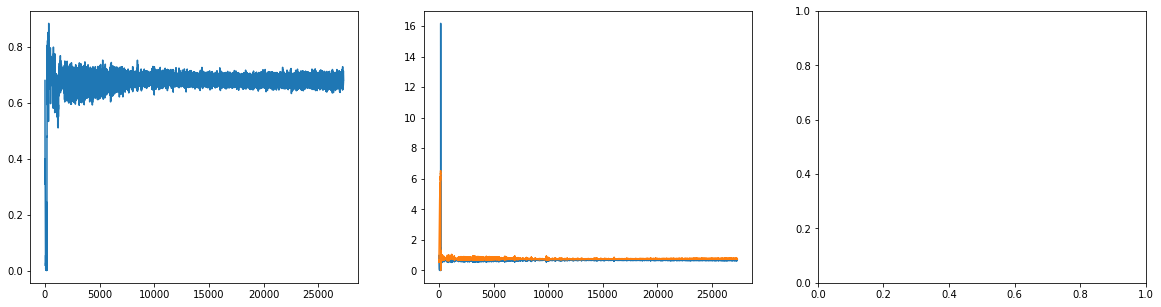

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(hash['d_loss1'], color='C0')
axs[1].plot(hash['d_loss2'], color='C0')
axs[1].plot(hash['g_loss'], color='C1')